In [4]:
# required imports
from vivarium.plots.simulation_output import _save_fig_to_dir as save_fig_to_dir
import ast
from escher import Builder
%matplotlib inline
import matplotlib.pyplot as plt
from vivarium.plots.topology import plot_topology

In [5]:
# Import the DynamicFBA class and the main function from the dFBA_process.py file
import sys
sys.path.append('../Models')
from dFBA_processes import DynamicFBA, main



In [13]:
# Set the desired model_path
model_path = "../SBML/e_coli_core.xml"
simulation_time = 50
# Call the main function with the
output, processes, topology = main(model_path, simulation_time)





Simulation ID: 3289c1e8-e38a-11ed-97c2-ba21c95c07d9
Created: 04/25/2023 at 12:57:01
Completed in 0.191133 seconds


In [14]:
output

"{ 0: { 'fluxes_values': {},\n       'objective_flux_value': 0.0,\n       'reaction_bounds': { 'ACALD': [-1000.0, 1000.0],\n                            'ACALDt': [-1000.0, 1000.0],\n                            'ACKr': [-1000.0, 1000.0],\n                            'ACONTa': [-1000.0, 1000.0],\n                            'ACONTb': [-1000.0, 1000.0],\n                            'ACt2r': [-1000.0, 1000.0],\n                            'ADK1': [-1000.0, 1000.0],\n                            'AKGDH': [0.0, 1000.0],\n                            'AKGt2r': [-1000.0, 1000.0],\n                            'ALCD2x': [-1000.0, 1000.0],\n                            'ATPM': [8.39, 1000.0],\n                            'ATPS4r': [-1000.0, 1000.0],\n                            'BIOMASS_Ecoli_core_w_GAM': [0.0, 1000.0],\n                            'CO2t': [-1000.0, 1000.0],\n                            'CS': [0.0, 1000.0],\n                            'CYTBD': [0.0, 1000.0],\n                      

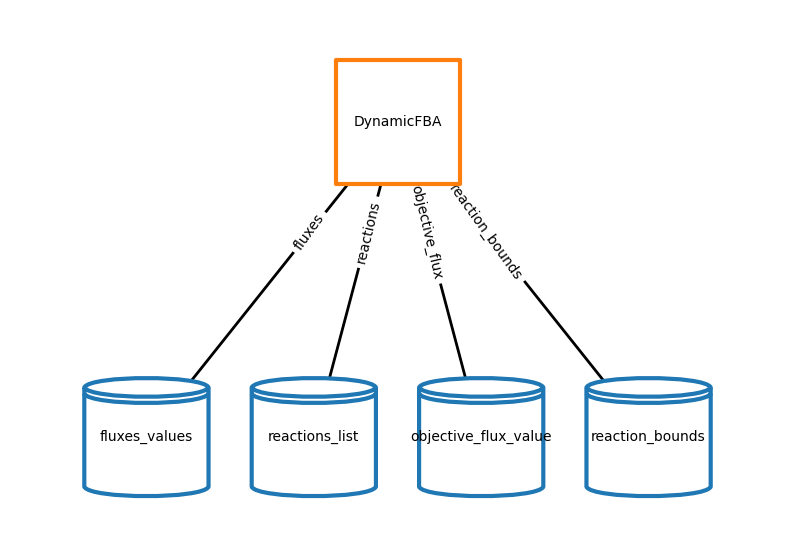

In [9]:
composite = {'processes' : processes , 'topology' : topology , 'steps' : {}, 'flow' : {}}
config ={'font_size' : 10}
fig_topology = plot_topology(composite, config)

In [10]:
# extract the fluxes data
if isinstance(output, str):
    # convert the string to a dictionary
    output = ast.literal_eval(output)
flux_data = output[1]['fluxes_values']
reactions_data = output[1]['reactions_list']
objective_flux_data = output[1]['objective_flux_value']
reaction_bounds_data = output[1]['reaction_bounds']

#Escher
# Load the E. coli core map
builder = Builder(
    map_name="e_coli_core.Core metabolism",     #user should choose it. 
    reaction_data=flux_data,
    show_gene_reaction_rules=False,
)

# Save the Escher plot as an HTML file
builder.save_html("../Plots/escher_plot__dFBA.html")

builder

Builder(reaction_data={'ACALD': 0.0, 'ACALDt': 0.0, 'ACKr': 2.0594933645192757e-15, 'ACONTa': 5.40652461781532…